In [1]:
#packages inginstaleerd
# !pip install geopandas
# !pip install geopandas matplotlib

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from scipy import stats
import seaborn as sns



# imprteren van data sets:
de in gepoteerde datasets zijn:
- Sensornet

In [2]:


pd.set_option("display.max_columns", None)

# Define time range
start_date = int(pd.to_datetime('2025-03-23').timestamp())
end_date = int(pd.to_datetime('2025-03-25').timestamp())

# Define URL properly formatted
url = (
    f"https://sensornet.nl/dataserver3/event/collection/nina_events/stream"
    f"?conditions%5B0%5D%5B%5D=time&conditions%5B0%5D%5B%5D=%3E%3D&conditions%5B0%5D%5B%5D={start_date}"
    f"&conditions%5B1%5D%5B%5D=time&conditions%5B1%5D%5B%5D=%3C&conditions%5B1%5D%5B%5D={end_date}"
    f"&conditions%5B2%5D%5B%5D=label&conditions%5B2%5D%5B%5D=in&conditions%5B2%5D%5B2%5D%5B%5D=21"
    f"&conditions%5B2%5D%5B2%5D%5B%5D=32&conditions%5B2%5D%5B2%5D%5B%5D=33&conditions%5B2%5D%5B2%5D%5B%5D=34"
    f"&args%5B%5D=aalsmeer&args%5B%5D=schiphol"
    f"&fields%5B%5D=time&fields%5B%5D=location_short&fields%5B%5D=location_long&fields%5B%5D=duration"
    f"&fields%5B%5D=SEL&fields%5B%5D=SELd&fields%5B%5D=SELe&fields%5B%5D=SELn&fields%5B%5D=SELden"
    f"&fields%5B%5D=SEL_dB&fields%5B%5D=lasmax_dB&fields%5B%5D=callsign&fields%5B%5D=type"
    f"&fields%5B%5D=altitude&fields%5B%5D=distance&fields%5B%5D=winddirection"
    f"&fields%5B%5D=windspeed&fields%5B%5D=label&fields%5B%5D=hex_s&fields%5B%5D=registration"
    f"&fields%5B%5D=icao_type&fields%5B%5D=serial&fields%5B%5D=operator&fields%5B%5D=tags"
)

# Make request with error handling
response = requests.get(url)


json_data = response.json()
colnames = pd.DataFrame(json_data.get('metadata', []))
data = pd.DataFrame(json_data.get('rows', []))

if not colnames.empty and 'headers' in colnames:
            data.columns = colnames['headers']

            # Convert time column to datetime
            data['time'] = pd.to_datetime(data['time'], unit='s')
            print("Time range:", data['time'].min(), "to", data['time'].max())

            # Display first few rows
            print(data.head())
df = data
df.head(30)

df['location_long'].unique

Time range: 2025-03-23 03:16:00 to 2025-03-24 23:30:27
headers         id location_short   location_long                time  \
0        132512331             Aa  Aalsmeerderweg 2025-03-23 05:56:04   
1        132512341             Aa  Aalsmeerderweg 2025-03-23 05:59:57   
2        132512361             Aa  Aalsmeerderweg 2025-03-23 06:05:38   
3        132512371             Aa  Aalsmeerderweg 2025-03-23 06:08:38   
4        132512381             Aa  Aalsmeerderweg 2025-03-23 06:11:23   

headers       SELd  SELe       SELn      SELden        SEL     SEL_dB  \
0                0     0  263093000  2630930000  263093000  84.201088   
1         97838300     0  483989000  4937730000  581828000  87.647943   
2        187415000     0          0   187415000  187415000  82.728040   
3        105051000     0          0   105051000  105051000  80.213990   
4        357945000     0          0   357945000  357945000  85.538159   

headers  lasmax_dB  distance  altitude  label  windspeed  winddirec

<bound method Series.unique of 0       Aalsmeerderweg
1       Aalsmeerderweg
2       Aalsmeerderweg
3       Aalsmeerderweg
4       Aalsmeerderweg
             ...      
4710           Hornweg
4711           Hornweg
4712           Hornweg
4713           Hornweg
4714           Hornweg
Name: location_long, Length: 4715, dtype: object>

Data cleanen 

In [3]:
df_filtered = df[df['lasmax_dB'] < 120]

df= df_filtered

In [4]:
df = df.dropna(subset=['altitude'])

In [5]:
df = df.drop_duplicates(subset=['altitude'])

In [6]:
df['altitude'] = pd.to_numeric(df['altitude'], errors='coerce')

In [7]:
# Gegeven waarden
d_diagonaal = df['distance'] # m
d_hoogte = df['altitude']  # m
L1 = df['lasmax_dB']  # dB

# Afstand van waarnemer tot vliegtuig
d1 = d_diagonaal

# Afstand direct onder vliegtuig
d2 = d_hoogte

# Berekening geluidsniveau onder vliegtuig
L2 = L1 + 20 * np.log10(d1 / d2)
df["max_db_onder"]= L2
df.head(10)
pd.set_option('display.max_rows', None)
unique_types = df['type'].unique()
print(unique_types)

['Embraer ERJ190-100STD' 'Boeing 737-800' 'Embraer ERJ 170-200 STD'
 'Airbus A319 111' 'Embraer ERJ190-100LR' 'Embraer EMB-175 LR' None
 'Airbus A319-111' 'Cessna Citation XLS' 'Embraer ERJ 190-100 STD'
 'Boeing 737-700' 'Embraer EMB-170 STD' 'Airbus A320-271N'
 'Airbus A320-214SL' 'Boeing 777-300ER' 'Boeing 737-900'
 'Embraer EMB-195 LR' 'Airbus SAS A330-203' 'Boeing 777-200'
 'Boeing 777 31HER' 'Airbus SAS A330-303' 'Boeing 737-8H6/W'
 'Boeing 737NG 958ER/W' 'Airbus A320 - 214SL' 'Airbus A320 216'
 'Airbus A300 B4-622RF' 'Airbus A330 343E' 'Airbus A330 243'
 'Airbus A318 111' 'Airbus A350 941' 'Airbus A330 302'
 'Boeing 737NG 8AS/W' 'Dassault Falcon 900EX' 'Embraer Phenom 300'
 'Airbus A380 861' 'Boeing 787-9' 'Airbus A319 112' 'Boeing 777 3DZER'
 'Boeing 787 9' 'Airbus A320 214' 'Dassault Falcon 2000EX EASy'
 'Airbus A320 232' 'Boeing 777F' 'Airbus A321 211' 'Boeing 747 8B5F'
 'Boeing 747 4R7F' 'Boeing 787 8' 'Airbus A320 214SL'
 'Canadair CL-600-2B19 CRJ-200LR' 'Boeing 777 3FXER' '

In [8]:
# Gegevens
types = df['type']
# Maak een lijst met de veel voorkomende types (de eerste woorden)
types_to_group = [
    'Airbus A320', 'Airbus A330', 'Airbus A350', 'Boeing 737', 'Boeing 777', 
    'Boeing 787', 'Boeing 747', 'Embraer ERJ', 'Canadair CRJ', 'Cessna', 
    'Bombardier', 'Embraer EMB', 'Airbus A319', 'Boeing 767', 'Fokker', 
    'Airbus A321', 'Airbus A318', 'Boeing 767', 'Textron Aviation'
]

# Mappen naar basis types
mapper = {}

# Voor elk type dat we moeten groeperen, kijk naar de eerste paar woorden
for aircraft in types:
    if isinstance(aircraft, str):  # Controleren of de waarde een string is
        for type_name in types_to_group:
            if aircraft.startswith(type_name):
                if type_name not in mapper:
                    mapper[aircraft] = type_name
                else:
                    mapper[aircraft] = type_name

# De dictionary bevat nu de mappen van versies naar hun basisnaam
print(mapper)

# Hier kun je de vervangingen doorvoeren
df['type'] = df['type'].replace(mapper)

# Toon de dataframe na de vervangingen
df.head()

{'Embraer ERJ190-100STD': 'Embraer ERJ', 'Boeing 737-800': 'Boeing 737', 'Embraer ERJ 170-200 STD': 'Embraer ERJ', 'Airbus A319 111': 'Airbus A319', 'Embraer ERJ190-100LR': 'Embraer ERJ', 'Embraer EMB-175 LR': 'Embraer EMB', 'Airbus A319-111': 'Airbus A319', 'Cessna Citation XLS': 'Cessna', 'Embraer ERJ 190-100 STD': 'Embraer ERJ', 'Boeing 737-700': 'Boeing 737', 'Embraer EMB-170 STD': 'Embraer EMB', 'Airbus A320-271N': 'Airbus A320', 'Airbus A320-214SL': 'Airbus A320', 'Boeing 777-300ER': 'Boeing 777', 'Boeing 737-900': 'Boeing 737', 'Embraer EMB-195 LR': 'Embraer EMB', 'Boeing 777-200': 'Boeing 777', 'Boeing 777 31HER': 'Boeing 777', 'Boeing 737-8H6/W': 'Boeing 737', 'Boeing 737NG 958ER/W': 'Boeing 737', 'Airbus A320 - 214SL': 'Airbus A320', 'Airbus A320 216': 'Airbus A320', 'Airbus A330 343E': 'Airbus A330', 'Airbus A330 243': 'Airbus A330', 'Airbus A318 111': 'Airbus A318', 'Airbus A350 941': 'Airbus A350', 'Airbus A330 302': 'Airbus A330', 'Boeing 737NG 8AS/W': 'Boeing 737', 'Boei

headers,id,location_short,location_long,time,SELd,SELe,SELn,SELden,SEL,SEL_dB,lasmax_dB,distance,altitude,label,windspeed,winddirection,callsign,type,tags,duration,hex_s,registration,icao_type,serial,operator,max_db_onder
0,132512331,Aa,Aalsmeerderweg,2025-03-23 05:56:04,0,0,263093000,2630930000,263093000,84.201088,74.9,753.605,610.145,21,4.0,124.0,KLM1917,Embraer ERJ,Aalsmeerbaan18L_T,56,485065,PH-EZZ,E190,19000654,KLM Cityhopper,76.734214
1,132512341,Aa,Aalsmeerderweg,2025-03-23 05:59:57,97838300,0,483989000,4937730000,581828000,87.647943,77.7,843.935,495.684,21,4.0,124.0,KLM1601,Boeing 737,Kaagbaan24_T,75,484130,PH-BXA,B738,29131,,82.322082
2,132512361,Aa,Aalsmeerderweg,2025-03-23 06:05:38,187415000,0,0,187415000,187415000,82.728040,71.4,878.388,693.133,21,4.0,115.0,KLM13H,Embraer ERJ,Aalsmeerbaan36R_T,76,4852F4,PH-EXG,E75L,17000546,,73.457396
3,132512371,Aa,Aalsmeerderweg,2025-03-23 06:08:38,105051000,0,0,105051000,105051000,80.213990,68.0,1197.090,610.446,21,4.0,115.0,ITY119,Airbus A319,Aalsmeerbaan18L_T,69,4CA98A,EI-IMN,A319,4764,Alitalia,73.849591
4,132512381,Aa,Aalsmeerderweg,2025-03-23 06:11:23,357945000,0,0,357945000,357945000,85.538159,75.8,723.849,569.971,21,4.0,111.0,KLM29L,Embraer ERJ,Aalsmeerbaan36R_T,52,484F7E,PH-EZV,E190,19000528,KLM Cityhopper,77.875905


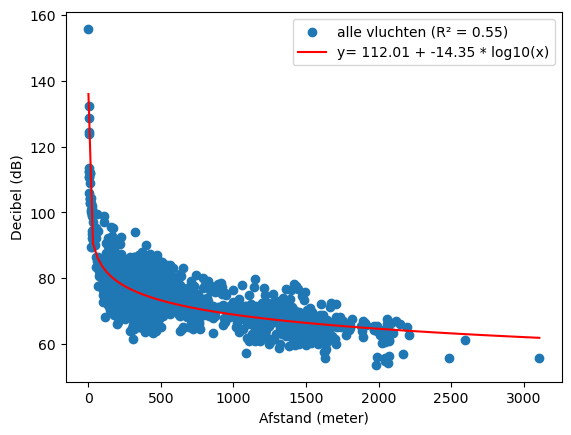

De aangepaste formule is: decibel = 112.01 + -14.35 * log10(afstand)
R²-waarde: 0.55


In [9]:
# Verwijder ongeldige waarden (NaN of oneindige waarden) in de relevante kolommen
cleaned_df = df.dropna(subset=['max_db_onder', 'altitude'])
cleaned_df = cleaned_df[~cleaned_df['max_db_onder'].isin([float('inf'), float('-inf')])]

# Sorteer de DataFrame op 'altitude'
cleaned_df = cleaned_df.sort_values(by='altitude')

# Gegeven data (vervang deze met jouw eigen data)
afstanden = cleaned_df['altitude']
decibels = cleaned_df['max_db_onder']

def logaritmische_functie(afstand, a, b):
    return a + b * np.log10(afstand)

parameters, covariantie = curve_fit(logaritmische_functie, afstanden, decibels)
a, b = parameters

# Genereer punten voor de vloeiende lijn
x_fit = np.linspace(min(afstanden), max(afstanden), 100)
y_fit = logaritmische_functie(x_fit, a, b)

# Bereken de R²-waarde
y_pred = logaritmische_functie(afstanden, a, b)
r2 = r2_score(decibels, y_pred)

plt.scatter(afstanden, decibels, label=f"alle vluchten (R² = {r2:.2f})")
plt.plot(x_fit, y_fit, color="red", label="y= 112.01 + -14.35 * log10(x)")
plt.xlabel("Afstand (meter)")
plt.ylabel("Decibel (dB)")
plt.legend()
plt.show()

print(f"De aangepaste formule is: decibel = {a:.2f} + {b:.2f} * log10(afstand)")
print(f"R²-waarde: {r2:.2f}")

In [10]:
# Test

x=2000
y= 112.01 + -14.35 * np.log10(x)
print(y)

64.64021956222187


## Logaritmische coefficient bepaling voor de meest voorkomende vliegtuig modellen

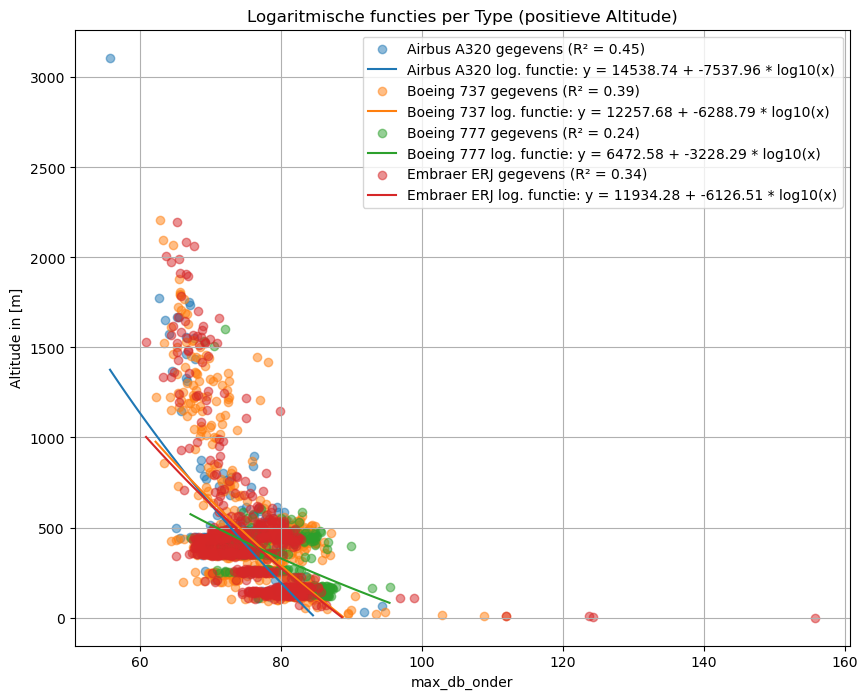

Airbus A320: y = 14538.74 + -7537.96 * log10(x), R² = 0.45
Boeing 737: y = 12257.68 + -6288.79 * log10(x), R² = 0.39
Boeing 777: y = 6472.58 + -3228.29 * log10(x), R² = 0.24
Embraer ERJ: y = 11934.28 + -6126.51 * log10(x), R² = 0.34


In [11]:
# Eerst filteren we de DataFrame op basis van het aantal gegevenspunten per 'type'
filtered_df = df.groupby('type').filter(lambda x: len(x) >= 200)

plt.figure(figsize=(10, 8))  # Vergroot de grafiek voor betere leesbaarheid

legend_labels = []  # Lijst voor legenda-labels

for label, group in filtered_df.groupby('type'):
    afstanden = group['max_db_onder']
    decibels = group['altitude']

    def logaritmische_functie(afstand, a, b):
        return a + b * np.log10(afstand)

    parameters, covariantie = curve_fit(logaritmische_functie, afstanden, decibels)
    a, b = parameters

    # Genereer punten voor de vloeiende lijn
    x_fit = np.linspace(min(afstanden), max(afstanden), 100)
    y_fit = logaritmische_functie(x_fit, a, b)

    # Bereken de R²-waarde
    y_pred = logaritmische_functie(afstanden, a, b)
    r2 = r2_score(decibels, y_pred)

    # Filter de punten om alleen positieve y-waarden te behouden
    positieve_indices = y_fit >= 0
    x_fit_positief = x_fit[positieve_indices]
    y_fit_positief = y_fit[positieve_indices]

    # Plot de scatterplot en de logaritmische functie voor elk type
    plt.scatter(afstanden, decibels, label=f'{label} gegevens (R² = {r2:.2f})', alpha=0.5)  # Transparantie toegevoegd
    plt.plot(x_fit_positief, y_fit_positief, label=f'{label} log. functie: y = {a:.2f} + {b:.2f} * log10(x)')
    
    # Voeg de formule toe aan de legenda
    legend_labels.append(f'{label}: y = {a:.2f} + {b:.2f} * log10(x)')

plt.xlabel('max_db_onder')
plt.ylabel('Altitude in [m]')
plt.title('Logaritmische functies per Type (positieve Altitude)')
plt.legend()
plt.grid(True)  # Voeg een raster toe voor betere leesbaarheid
plt.show()

# Print de formules en R²-waarden in de console
for label, group in filtered_df.groupby('type'):
    afstanden = group['max_db_onder']
    decibels = group['altitude']
    parameters, _ = curve_fit(logaritmische_functie, afstanden, decibels)
    a, b = parameters
    y_pred = logaritmische_functie(afstanden, a, b)
    r2 = r2_score(decibels, y_pred)
    print(f"{label}: y = {a:.2f} + {b:.2f} * log10(x), R² = {r2:.2f}")

In [12]:
x= 0

y= -0.03* x +89
print(y)

89.0


<Figure size 800x600 with 0 Axes>

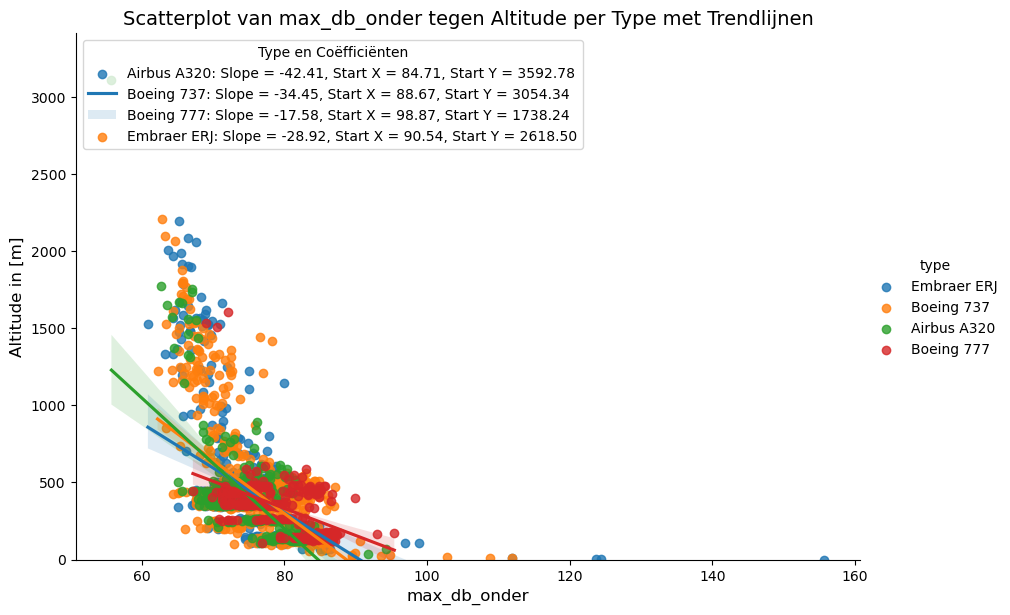

,type,slope,start_x,start_y
0,Airbus A320,-42.413970,84.707585,3592.784973
1,Boeing 737,-34.445993,88.670366,3054.338837
2,Boeing 777,-17.580523,98.872860,1738.236556
3,Embraer ERJ,-28.921824,90.537104,2618.498154


In [13]:
# Eerst filteren we de DataFrame op basis van het aantal gegevenspunten per 'type'
filtered_df = df.groupby('type').filter(lambda x: len(x) >= 200)

# Maak de scatterplot met trendlijnen gesplitst op type (nu met gefilterde data)
plt.figure(figsize=(8, 6))
sns.lmplot(x='max_db_onder', y='altitude', data=filtered_df, hue='type', markers='o', height=6, aspect=1.5)

# Bereken de richtingscoëfficiënt, start_x (snijpunt met x-as) en start_y (snijpunt met y-as)
legend_labels = []
startpunten = []

for label, group in filtered_df.groupby('type'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(group['max_db_onder'], group['altitude'])
    
    # Controleer of slope geldig is om deling door nul te voorkomen
    if pd.isna(slope) or slope == 0:
        start_x = None  # Geen geldig startpunt op x-as
        slope = 0  
    else:
        start_x = -intercept / slope  # Bereken het snijpunt met de x-as
    
    start_y = intercept  # Snijpunt met de y-as
    
    # Voeg toe aan de lijst met labels
    legend_labels.append(f'{label}: Slope = {slope:.2f}, Start X = {start_x:.2f}, Start Y = {start_y:.2f}' if start_x is not None else f'{label}: Slope = {slope:.2f}, Start X = N/A, Start Y = {start_y:.2f}')
    
    # Voeg toe aan de dataframe lijst
    startpunten.append({'type': label, 'slope': slope, 'start_x': start_x, 'start_y': start_y})

# Maak een dataframe met de startpunten en richtingscoëfficiënten
startpunten_df = pd.DataFrame(startpunten)

# Voeg de aangepaste legenda toe
plt.legend(title='Type en Coëfficiënten', labels=legend_labels, loc='upper left', fontsize=10)

# Voeg titels en labels toe
plt.title('Scatterplot van max_db_onder tegen Altitude per Type met Trendlijnen', fontsize=14)
plt.xlabel('max_db_onder', fontsize=12)
plt.ylabel('Altitude in [m]', fontsize=12)

# Stel de limieten voor de y-as in zodat deze niet onder nul gaat
plt.ylim(bottom=0)

# Toon de plot
plt.show()

# Toon het dataframe met startpunten
startpunten_df.head(40) 


## Kwadratische bepaling van coeffienten

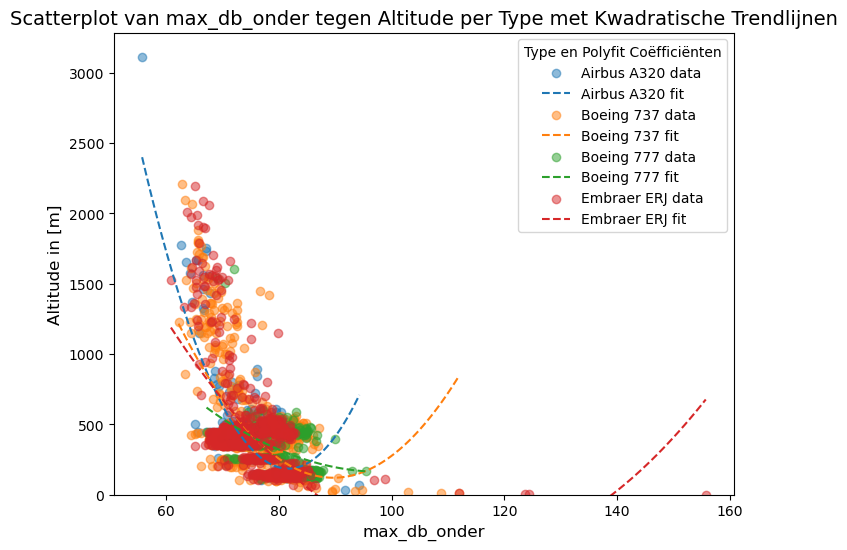

In [14]:
# Eerst filteren we de DataFrame op basis van het aantal gegevenspunten per 'type'
filtered_df = df.groupby('type').filter(lambda x: len(x) >= 200)

# Maak de scatterplot met trendlijnen gesplitst op type
plt.figure(figsize=(8, 6))
colors = sns.color_palette(n_colors=filtered_df['type'].nunique())

legend_labels = []

for (label, group), color in zip(filtered_df.groupby('type'), colors):
    x = group['max_db_onder'].values
    y = group['altitude'].values
    
    # Bereken een polyfit van de tweede graad (kwadratisch)
    coeffs = np.polyfit(x, y, 2)
    poly_eq = np.poly1d(coeffs)
    
    # Genereer x-waarden voor de trendlijn
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = poly_eq(x_fit)
    
    # Plot de scatter en de polyfit lijn
    plt.scatter(x, y, label=f'{label} data', color=color, alpha=0.5)
    plt.plot(x_fit, y_fit, label=f'{label} fit', color=color, linestyle='--')
    
    legend_labels.append(f'{label}: y = {coeffs[0]:.4f}x² + {coeffs[1]:.4f}x + {coeffs[2]:.4f}')

# Voeg de aangepaste legenda toe
plt.legend(title='Type en Polyfit Coëfficiënten', fontsize=10)

# Voeg titels en labels toe
plt.title('Scatterplot van max_db_onder tegen Altitude per Type met Kwadratische Trendlijnen', fontsize=14)
plt.xlabel('max_db_onder', fontsize=12)
plt.ylabel('Altitude in [m]', fontsize=12)

# Stel de limieten voor de y-as in zodat deze niet onder nul gaat
plt.ylim(bottom=0)

# Toon de plot
plt.show()


## Hyberbolische bepaling van coefficient

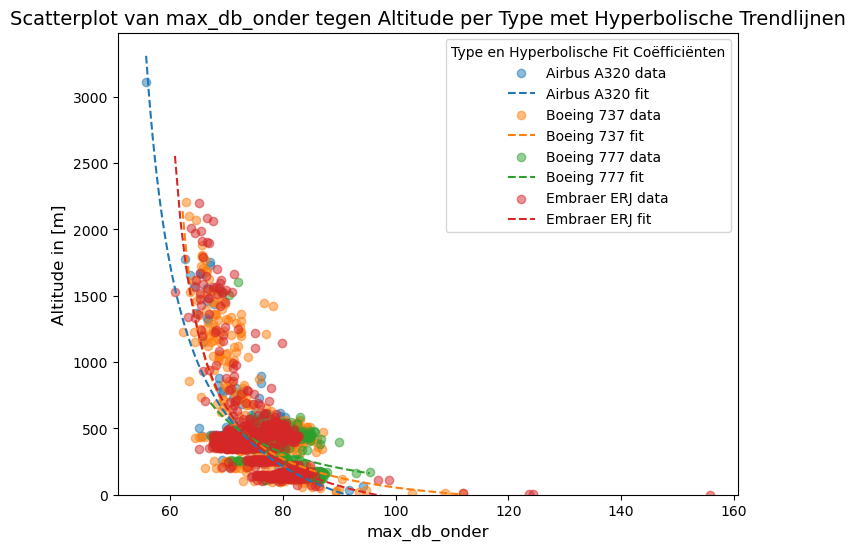

In [15]:
# Eerst filteren we de DataFrame op basis van het aantal gegevenspunten per 'type'
filtered_df = df.groupby('type').filter(lambda x: len(x) >= 200)

# Definieer een aangepaste hyperbolische functie
def hyperbolic_func(x, a, b, c):
    return a / (x + b) + c

# Maak de scatterplot met trendlijnen gesplitst op type
plt.figure(figsize=(8, 6))
colors = sns.color_palette(n_colors=filtered_df['type'].nunique())

legend_labels = []

for (label, group), color in zip(filtered_df.groupby('type'), colors):
    x = group['max_db_onder'].values
    y = group['altitude'].values
    
    # Geef een redelijke startwaarde voor de fit
    initial_guess = [np.median(y) * np.median(x), np.median(x), np.median(y)]
    
    # Pas de hyperbolische fit toe
    try:
        popt, _ = curve_fit(hyperbolic_func, x, y, p0=initial_guess, maxfev=10000)
        
        # Genereer x-waarden voor de trendlijn
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = hyperbolic_func(x_fit, *popt)
        
        # Plot de scatter en de fit lijn
        plt.scatter(x, y, label=f'{label} data', color=color, alpha=0.5)
        plt.plot(x_fit, y_fit, label=f'{label} fit', color=color, linestyle='--')
        
        legend_labels.append(f'{label}: y = {popt[0]:.4f} / (x + {popt[1]:.4f}) + {popt[2]:.4f}')
    except RuntimeError:
        legend_labels.append(f'{label}: Fit kon niet worden berekend')

# Voeg de aangepaste legenda toe
plt.legend(title='Type en Hyperbolische Fit Coëfficiënten', fontsize=10)

# Voeg titels en labels toe
plt.title('Scatterplot van max_db_onder tegen Altitude per Type met Hyperbolische Trendlijnen', fontsize=14)
plt.xlabel('max_db_onder', fontsize=12)
plt.ylabel('Altitude in [m]', fontsize=12)

# Stel de limieten voor de y-as in zodat deze niet onder nul gaat
plt.ylim(bottom=0)

# Toon de plot
plt.show()



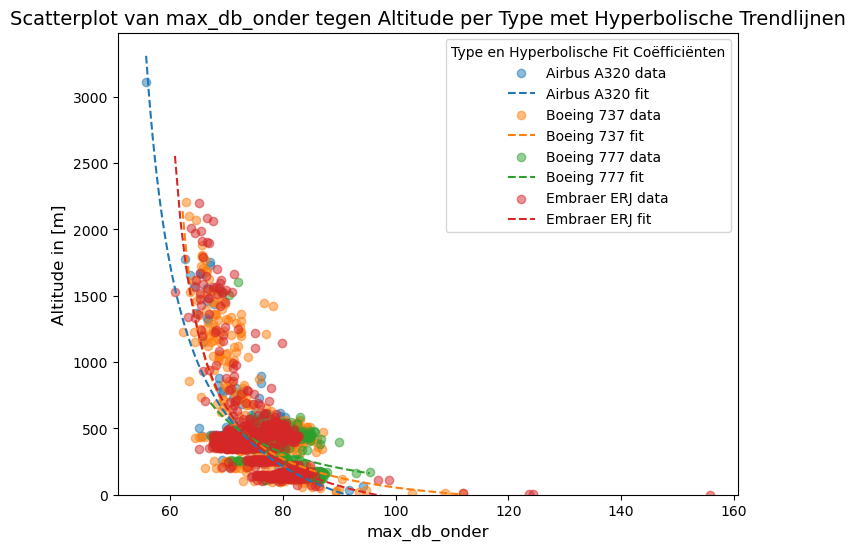

,type,a,b,c,formula
0,Airbus A320,24295.474053,-49.496853,-583.941717,Airbus A320: y = 24295.4741 / (x + -49.4969) +...
1,Boeing 737,10054.359926,-57.876619,-185.717355,Boeing 737: y = 10054.3599 / (x + -57.8766) + ...
2,Boeing 777,12021.791173,-52.346689,-119.241881,Boeing 777: y = 12021.7912 / (x + -52.3467) + ...
3,Embraer ERJ,14069.740887,-56.004841,-349.130327,Embraer ERJ: y = 14069.7409 / (x + -56.0048) +...


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

# Eerst filteren we de DataFrame op basis van het aantal gegevenspunten per 'type'
filtered_df = df.groupby('type').filter(lambda x: len(x) >= 200)

# Definieer een aangepaste hyperbolische functie
def hyperbolic_func(x, a, b, c):
    return a / (x + b) + c

# Maak de scatterplot met trendlijnen gesplitst op type
plt.figure(figsize=(8, 6))
colors = sns.color_palette(n_colors=filtered_df['type'].nunique())

legend_labels = []
formules = []

for (label, group), color in zip(filtered_df.groupby('type'), colors):
    x = group['max_db_onder'].values
    y = group['altitude'].values
    
    # Geef een redelijke startwaarde voor de fit
    initial_guess = [np.median(y) * np.median(x), np.median(x), np.median(y)]
    
    # Pas de hyperbolische fit toe
    try:
        popt, _ = curve_fit(hyperbolic_func, x, y, p0=initial_guess, maxfev=10000)
        
        # Genereer x-waarden voor de trendlijn
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = hyperbolic_func(x_fit, *popt)
        
        # Plot de scatter en de fit lijn
        plt.scatter(x, y, label=f'{label} data', color=color, alpha=0.5)
        plt.plot(x_fit, y_fit, label=f'{label} fit', color=color, linestyle='--')
        
        formule = f'{label}: y = {popt[0]:.4f} / (x + {popt[1]:.4f}) + {popt[2]:.4f}'
        legend_labels.append(formule)
        formules.append({'type': label, 'a': popt[0], 'b': popt[1], 'c': popt[2], 'formula': formule})
    except RuntimeError:
        legend_labels.append(f'{label}: Fit kon niet worden berekend')

# Voeg de aangepaste legenda toe
plt.legend(title='Type en Hyperbolische Fit Coëfficiënten', fontsize=10)

# Voeg titels en labels toe
plt.title('Scatterplot van max_db_onder tegen Altitude per Type met Hyperbolische Trendlijnen', fontsize=14)
plt.xlabel('max_db_onder', fontsize=12)
plt.ylabel('Altitude in [m]', fontsize=12)

# Stel de limieten voor de y-as in zodat deze niet onder nul gaat
plt.ylim(bottom=0)

# Toon de plot
plt.show()

# Zet de formules in een DataFrame en toon deze
formules_df = pd.DataFrame(formules)
formules_df.head()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

# Verwijder de filtering en gebruik de volledige DataFrame
df_to_use = df

# Definieer een aangepaste hyperbolische functie
def hyperbolic_func(x, a, b, c):
    return a / (x + b) + c

# Maak de scatterplot met één trendlijn voor de gehele dataset
plt.figure(figsize=(8, 6))

# Kies een kleur voor de scatterplot (je kunt hier zelf een kleur kiezen)
color = sns.color_palette("viridis", as_cmap=True)(0.5)  # Bijvoorbeeld een kleur uit het 'viridis' palet

x = df_to_use['max_db_onder'].values
y = df_to_use['altitude'].values

# Geef een redelijke startwaarde voor de fit
initial_guess = [np.median(y) * np.median(x), np.median(x), np.median(y)]

# Pas de hyperbolische fit toe voor de gehele dataset
try:
    popt, _ = curve_fit(hyperbolic_func, x, y, p0=initial_guess, maxfev=10000)
    
    # Genereer x-waarden voor de trendlijn
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = hyperbolic_func(x_fit, *popt)
    
    # Plot de scatter en de fit lijn
    plt.scatter(x, y, label='Alle data', color=color, alpha=0.5)
    plt.plot(x_fit, y_fit, label='Hyperbolische trendlijn', color='red', linestyle='--')
    
    formule = f'y = {popt[0]:.4f} / (x + {popt[1]:.4f}) + {popt[2]:.4f}'
    plt.legend(title=f'Hyperbolische Fit Coëfficiënten: {formule}', fontsize=10)
except RuntimeError:
    plt.legend(title="Fit kon niet worden berekend", fontsize=10)

# Voeg titels en labels toe
plt.title('Scatterplot van max_db_onder tegen Altitude met Hyperbolische Trendlijn', fontsize=14)
plt.xlabel('max_db_onder', fontsize=12)
plt.ylabel('Altitude in [m]', fontsize=12)

# Stel de limieten voor de y-as in zodat deze niet onder nul gaat
plt.ylim(bottom=0)

# Toon de plot
plt.show()



ValueError: array must not contain infs or NaNs

<Figure size 800x600 with 0 Axes>

In [ ]:
# #formules
# Airbus A320: y = 24295.4741 / (x + -49.4969) -583.941717
# Boeing 737: y = 10054.3599 / (x + -57.8766)  -185.717355
# Boeing 777: y = 12021.7912 / (x + -52.3467) -119.241881	
# Embraer ERJ: y = 14069.7409 / (x + -56.0048) -349.130327

# Functie om het geluidsniveau te voorspellen op basis van de hoogte
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dataset (voorbeeld van de formules)
data = {
    "type": ["Airbus A320", "Boeing 737", "Boeing 777", "Embraer ERJ"],
    "a": [24295.4741, 10054.3599, 12021.7912, 14069.7409],  # Coëfficiënten voor 'a'
    "b": [-49.4969, -57.8766, -52.3467, -56.0048],            # Coëfficiënten voor 'b'

}

# Zet de dataset om in een DataFrame
df = pd.DataFrame(data)

# Functie om het geluidsniveau (y) te berekenen op basis van de hoogte (x) en de formule voor elk vliegtuigtype
def calculate_decibel(altitude, aircraft_type):
    # Zoek de rij voor het gegeven vliegtuig
    aircraft_data = df[df['type'] == aircraft_type].iloc[0]
    
    # Haal de coëfficiënten op voor dit vliegtuig
    a = aircraft_data['a']
    b = aircraft_data['b']

    # Bereken de decibelwaarde volgens de formule
    decibel = a / (altitude + b) 
    
    # Zorg ervoor dat de decibelwaarde niet onder nul gaat
    if decibel < 0:
        decibel = 0
    
    return decibel

# Voorbeeld: Bereken het geluidsniveau voor een Airbus A320 op 2000 meter hoogte
altitude = 
aircraft_type = "Airbus A320"  # Geef het type vliegtuig aan
decibel_value = calculate_decibel(altitude, aircraft_type)
print(f"Voorspelde geluidsniveau voor {aircraft_type} op {altitude}m: {decibel_value:.2f} dB")



Voorspelde geluidsniveau voor Airbus A320 op 800m: 32.37 dB


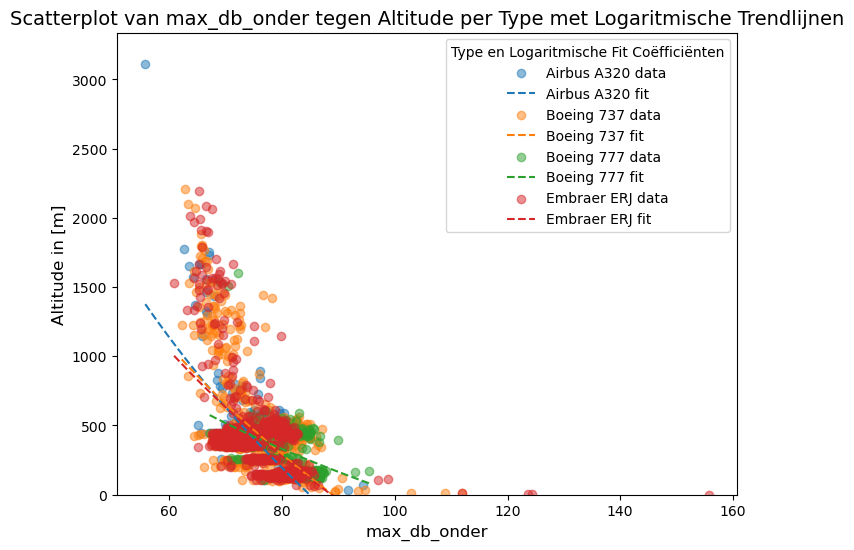

          type            a             b  \
0  Airbus A320 -3273.695175  14538.742044   
1   Boeing 737 -2731.187449  12257.675911   
2   Boeing 777 -1402.029125   6472.580007   
3  Embraer ERJ -2660.707720  11934.280878   

                                            formula  
0  Airbus A320: y = -3273.6952 * ln(x) + 14538.7420  
1   Boeing 737: y = -2731.1874 * ln(x) + 12257.6759  
2    Boeing 777: y = -1402.0291 * ln(x) + 6472.5800  
3  Embraer ERJ: y = -2660.7077 * ln(x) + 11934.2809  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

# Eerst filteren we de DataFrame op basis van het aantal gegevenspunten per 'type'
filtered_df = df.groupby('type').filter(lambda x: len(x) >= 200)

# Definieer een aangepaste logaritmische functie
def log_func(x, a, b):
    return a * np.log(x) + b

# Maak de scatterplot met trendlijnen gesplitst op type
plt.figure(figsize=(8, 6))
colors = sns.color_palette(n_colors=filtered_df['type'].nunique())

legend_labels = []
formules = []

for (label, group), color in zip(filtered_df.groupby('type'), colors):
    x = group['max_db_onder'].values
    y = group['altitude'].values
    
    # Geef een redelijke startwaarde voor de fit
    initial_guess = [np.median(y), np.median(y)]
    
    # Pas de logaritmische fit toe
    try:
        popt, _ = curve_fit(log_func, x, y, p0=initial_guess, maxfev=10000)
        
        # Genereer x-waarden voor de trendlijn
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = log_func(x_fit, *popt)
        
        # Plot de scatter en de fit lijn
        plt.scatter(x, y, label=f'{label} data', color=color, alpha=0.5)
        plt.plot(x_fit, y_fit, label=f'{label} fit', color=color, linestyle='--')
        
        formule = f'{label}: y = {popt[0]:.4f} * ln(x) + {popt[1]:.4f}'
        legend_labels.append(formule)
        formules.append({'type': label, 'a': popt[0], 'b': popt[1], 'formula': formule})
    except RuntimeError:
        legend_labels.append(f'{label}: Fit kon niet worden berekend')

# Voeg de aangepaste legenda toe
plt.legend(title='Type en Logaritmische Fit Coëfficiënten', fontsize=10)

# Voeg titels en labels toe
plt.title('Scatterplot van max_db_onder tegen Altitude per Type met Logaritmische Trendlijnen', fontsize=14)
plt.xlabel('max_db_onder', fontsize=12)
plt.ylabel('Altitude in [m]', fontsize=12)

# Stel de limieten voor de y-as in zodat deze niet onder nul gaat
plt.ylim(bottom=0)

# Toon de plot
plt.show()

# Zet de formules in een DataFrame en toon deze
formules_df = pd.DataFrame(formules)
print(formules_df)


In [ ]:
import pandas as pd

# Dataset
data = {
    "type": ["Airbus A320", "Boeing 737", "Boeing 777", "Embraer ERJ"],
    "slope": [-42.413970, -34.445993, -17.580523, -28.921824],
    "start_x": [84.707585, 88.670366, 98.872860, 90.537104],
    "start_y": [3592.784973, 3054.338837, 1738.236556, 2618.498154]
}

# Zet de dataset om in een DataFrame
df = pd.DataFrame(data)

# Functie om de decibel te berekenen op basis van de hoogte (start_y)
def calculate_decibel(altitude, aircraft_type):
    # Zoek de rij voor het gegeven vliegtuig
    aircraft_data = df[df['type'] == aircraft_type].iloc[0]
    
    # Haal de slope en start_x op uit de data van dit vliegtuig slope was verkeerd berekend. daarom wordt de sloop ^-1 gedaan
    slope = (aircraft_data['slope'])** -1 
    start_x = aircraft_data['start_x']
    
    # Bereken de decibel
    decibel = slope * altitude + start_x
    
    # Zorg ervoor dat de decibelwaarde niet onder nul gaat
    if decibel < 0:
        decibel = 0
    
    return decibel

# Test de functie
altitude = 1000
aircraft_type = "Boeing 737"  # Geef het type vliegtuig aan
decibel_value = calculate_decibel(altitude, aircraft_type)
print(decibel_value)




59.63941311093683


In [ ]:
opgeschoonde_sensornetdata =df.to_csv("opgeschoonde_sensornetdata.csv", sep=",", index=False)

opgeschoonde_sensornetdata.head()

In [ ]:

# Je bestaande functie (bereken de decibels)
def calculate_decibel(aircraft_type, altitude, slope, start_y):
    """
    Bereken het aantal decibel voor een bepaald type vliegtuig op een gegeven hoogte.
    
    Formule: y = slope * x + start_y
    
    Parameters:
        aircraft_type (str): Het type vliegtuig.
        altitude (float): De hoogte in meters.
        slope (float): De helling van de lijn.
        start_y (float): De y-intercept waarde.
    
    Returns:
        float: Het aantal decibel, minimaal 0.
    """
    y = slope * altitude + start_y
    return max(0, y)  # Zorgt ervoor dat de decibelwaarde niet onder 0 komt

# Functie om decibels voor elk vliegtuig in de DataFrame te berekenen
def calculate_decibels_for_df(df, altitude):
    df['decibel'] = df.apply(lambda row: calculate_decibel(row['type'], altitude, row['slope'], row['start_y']), axis=1)
    return df

# Stel de hoogte in (bijv. 200 meter)
hoogte = 100

# Bereken de decibelwaarden en voeg ze toe aan je DataFrame
startpunten_df = calculate_decibels_for_df(startpunten_df, hoogte)

# Toon het resultaat
print(startpunten_df[['type', 'decibel']])


          type  decibel
0  Airbus A320        0
1   Boeing 737        0
2   Boeing 777        0
3  Embraer ERJ        0


In [ ]:
import numpy as np

# Luchtabsorptiecoëfficiënt (bij 1000 Hz, 20°C, 50% vochtigheid)
alpha = 0.01  # dB per meter

# Afstanden uit de DataFrame
d_horizontaal = df['distance']  # m
d_hoogte = df['altitude']  # m

# Afstand van waarnemer tot vliegtuig
df['d1'] = np.sqrt(d_horizontaal**2 + d_hoogte**2)

# Afstand van meetpunt naar direct onder het vliegtuig (is gelijk aan de hoogte)
df['d2'] = d_hoogte

# Origineel geluidsniveau op meetpunt
L1 = df['SEL_dB']

# Toepassen van inverse kwadratenwet
df['L2_no_absorption'] = L1 + 20 * np.log10(df['d1'] / df['d2'])

# Toepassen van luchtabsorptie (tweemaal: vliegtuig → meetpunt & meetpunt → grond)
df['L2_with_absorption'] = df['L2_no_absorption'] - alpha * df['d1'] - alpha * df['d2']

df[['SEL_dB', 'L2_no_absorption', 'L2_with_absorption']].head()


KeyError: 'distance'